# Analysing GTSRB

In [16]:
import json
from pathlib import Path
import matplotlib.pyplot as plt


def _load_json(p: Path):
    with p.open("r", encoding="utf-8") as f:
        return json.load(f)


def plot_eval_acc_max_per_group(
    dataset_dir: str | Path,
    *,
    group_by: tuple[str, ...] = ("dropout", "augment"),
    show_print: bool = False,
    show_plot: bool = True,
    save_path: str | Path | None = None,
):
    """
    For a dataset folder like runs/LENET5/CIFAR10 or runs/LENET5/GTSRB:
      - reads all run subfolders with config.json + history.json
      - groups runs by keys in `group_by` (default: dropout + augment)
      - for each group picks the run with the maximum number of epochs
        (measured by len(history['eval_acc']) or config['epochs'])
      - plots eval_acc vs epoch per group (linestyle by augment)

    This matches your CIFAR10 situation where aug=1 was trained longer than aug=0.
    """
    dataset_dir = Path(dataset_dir)
    if not dataset_dir.exists() or not dataset_dir.is_dir():
        raise ValueError(f"dataset_dir does not exist or is not a dir: {dataset_dir}")

    # collect run dirs (your structure: dataset_dir/<run_name>/config.json etc.)
    run_dirs = [
        p for p in dataset_dir.iterdir()
        if p.is_dir() and (p / "config.json").exists() and (p / "history.json").exists()
    ]
    if not run_dirs:
        raise RuntimeError(f"No run folders with config.json+history.json found in: {dataset_dir}")

    runs = []
    for rd in run_dirs:
        try:
            cfg = _load_json(rd / "config.json")
            hist = _load_json(rd / "history.json")
        except Exception as e:
            print(f"[WARN] Skip {rd}: cannot read json ({e})")
            continue

        eval_acc = hist.get("eval_acc")
        if not isinstance(eval_acc, list) or len(eval_acc) == 0:
            print(f"[WARN] Skip {rd}: missing/empty history['eval_acc']")
            continue

        # parse fields (your config keys)
        try:
            dropout = float(cfg.get("dropout"))
        except Exception:
            dropout = cfg.get("dropout")

        try:
            augment = int(cfg.get("augment"))
        except Exception:
            augment = cfg.get("augment")

        # config epochs might exist but we primarily trust eval_acc length
        cfg_epochs = cfg.get("epochs")
        try:
            cfg_epochs = int(cfg_epochs)
        except Exception:
            cfg_epochs = None

        runs.append(
            {
                "run_dir": rd,
                "cfg": cfg,
                "eval_acc": eval_acc,
                "dropout": dropout,
                "augment": augment,
                "cfg_epochs": cfg_epochs,
            }
        )

    if not runs:
        raise RuntimeError(f"Found run dirs, but none were usable in: {dataset_dir}")

    # group and select max epochs run per group
    best = {}
    for r in runs:
        key_parts = []
        for k in group_by:
            if k == "dropout":
                key_parts.append(r["dropout"])
            elif k == "augment":
                key_parts.append(r["augment"])
            else:
                key_parts.append(r["cfg"].get(k))
        key = tuple(key_parts)

        # "epochs achieved" = length of eval_acc (most reliable)
        achieved_epochs = len(r["eval_acc"])

        if key not in best or achieved_epochs > len(best[key]["eval_acc"]):
            best[key] = r

    if show_print:
        print(f"\nDataset: {dataset_dir.name}")
        print(f"Runs found (usable): {len(runs)}")
        print(f"Groups ({group_by}) plotted: {len(best)}")
        for key, r in sorted(best.items(), key=lambda x: tuple(str(v) for v in x[0])):
            print("-" * 90)
            print(f"group={key} | run={r['run_dir'].name} | epochs_used={len(r['eval_acc'])}")

    # plot
    if show_plot or save_path is not None:
        # linestyle by augmentation (extend as needed)
        ls_map = {0: "-", 1: "--"}

        plt.figure(figsize=(10, 6))
        for key, r in sorted(best.items(), key=lambda x: tuple(str(v) for v in x[0])):
            y = r["eval_acc"]
            x = list(range(1, len(y) + 1))

            aug = r["augment"]
            ls = ls_map.get(aug, "-.")
            label = f"dropout={r['dropout']}, aug={aug}, epochs={len(y)}"

            plt.plot(x, y, linestyle=ls, label=label)

        plt.xlabel("epoch")
        plt.ylabel("test accuracy")
        plt.title(f"{dataset_dir.name}: test accuracy vs epoch (max epochs per group)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        if save_path is not None:
            save_path = Path(save_path)
            save_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, dpi=200)

        if show_plot:
            plt.show()
        else:
            plt.close()

    return best

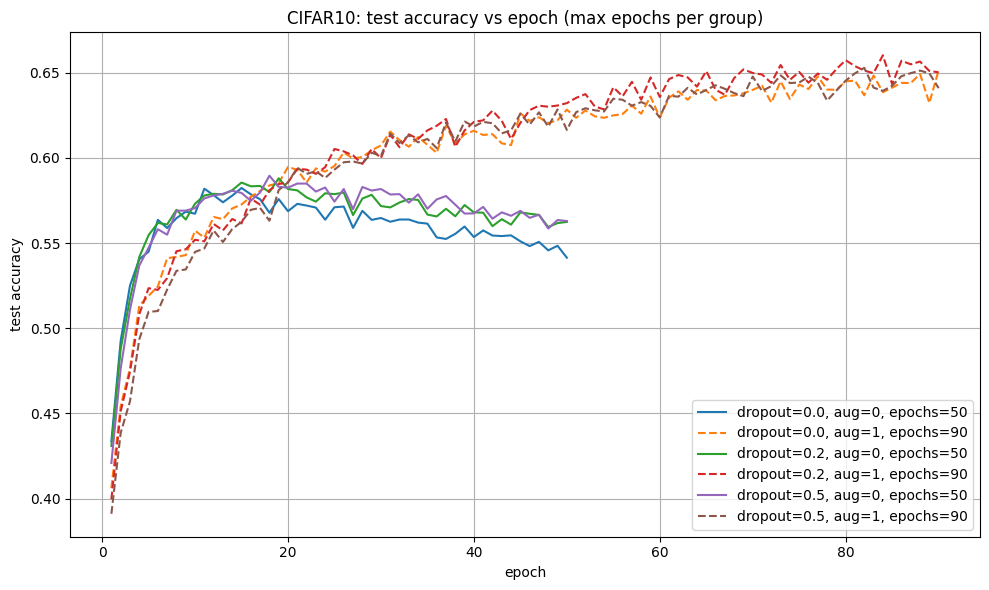

In [21]:
_ = plot_eval_acc_max_per_group("runs/test/LENET5/CIFAR10", save_path="plots/cifar10_test_acc.png")

# Analysing CIFAR-10

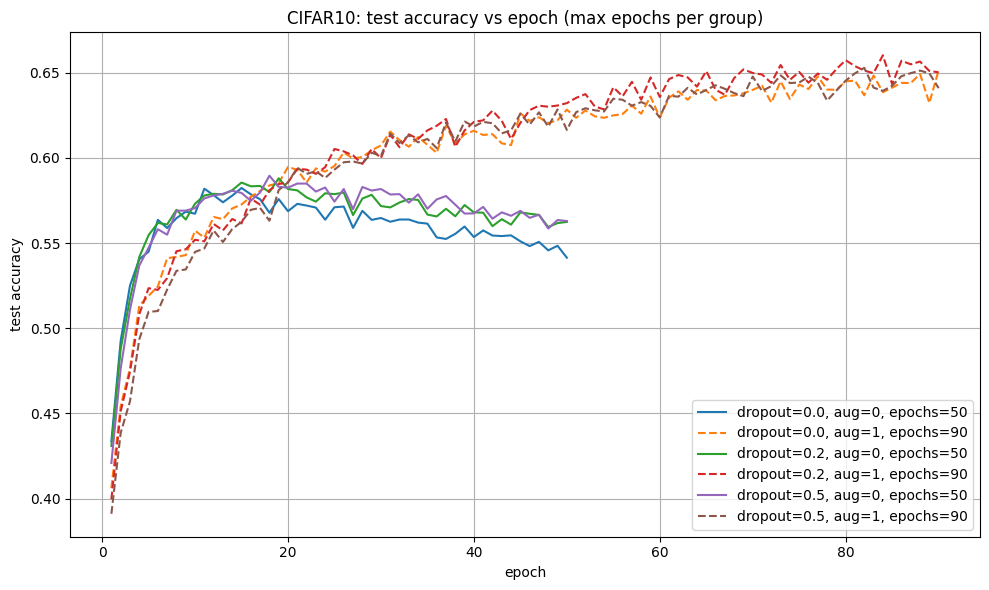

In [ ]:
_ = plot_eval_acc_max_per_group("runs/test/LENET5/CIFAR10", save_path="analysis_plots/cifar10_eval_acc.png")